In [1]:
import os
import cv2
import glob
import ntpath
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn import over_sampling
from keras.utils import np_utils 
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler,ModelCheckpoint
from keras.metrics import categorical_accuracy, categorical_crossentropy
from keras.layers import Input, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Concatenate, GlobalMaxPooling2D
from keras.layers.advanced_activations import ReLU

warnings.filterwarnings("ignore")

Using TensorFlow backend.
D:\Anaconda3\envs\my_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\my_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\my_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\my_keras\lib\site-packages\tensorflow\python\framework\d

In [2]:
USE_DROPOUT = False
LEARN_RATE = 0.001
Height = 128
Weight = 128
Channel= 3

In [ ]:
# #################################################################################
# #数据平衡处理
# df_1 = df_train.loc[df_train["cancer_label"]==1]
# df_0 = df_train.loc[df_train["cancer_label"]==0]
# df_1_add1 = df_1.sample(379)
# df_1_add2 = df_1.sample(378)
# df_1 = pandas.concat([df_1,df_1_add1,df_1_add2])
# df_train = pandas.concat([df_1,df_0])

Train Biopsy Count:  266 , Holdout Biopsy Count:  30
Train Biopsy Count:  266 , Holdout Biopsy Count:  30
Full Count:  91564
Train Nuclei Count:  81404 , Holdout Nuclei Count:  10160
train_samples_grade_0:  16672 , holdout_samples_grade_0:  2201
train_samples_grade_1:  16772 , holdout_samples_grade_1:  1690
train_samples_grade_2:  11597 , holdout_samples_grade_2:  1200
train_samples_grade_3:  27128 , holdout_samples_grade_3:  4306
train_samples_grade_4:  9235 , holdout_samples_grade_4:  763
Train Count:  81404 , Holdout Count:  10160
Train Sample_X:  135640 , Train Sample_Y:  135640
Train Count:  135640 , Holdout Count:  10160
Train Count:  135640 , Holdout Count:  10160
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input (InputLayer)                     (None, 128, 128, 3)        0           

Epoch 1/10
learnrate:  0.001  epoch:  0
   165/135640 [..............................] - ETA: 5:48:06 - loss: 1.1398 - categorical_accuracy: 0.5606 - categorical_crossentropy: 1.1398 ETA: 6:19:55 - loss: 1.1873 - cat

KeyboardInterrupt: 

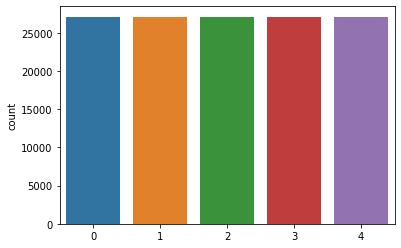

In [64]:
if __name__ == "__main__":
    
    if True:
            
        train(model_name="liver_CNN", load_weights_path=None)      
        

In [62]:
def train(model_name, load_weights_path):
    
    batch_size = 16

    for i in range(10):

        model_name_i =model_name + "_" + str(i+1)

        #获得训练和测试集合，以：路径、class label的形式保存
        train_files, holdout_files = get_train_holdout_files( current_iteration = (i+1) )

        #训练数据集
        train_gen = data_generator(batch_size, train_files, train_set=True)

        #测试数据集
        holdout_gen = data_generator(batch_size, holdout_files, train_set=False)

        #动态设置学习率
        learnrate_scheduler = LearningRateScheduler(step_decay)

        #获取model
        model = get_net(load_weight_path=load_weights_path)

        checkpoint = ModelCheckpoint("workdir/model_" + model_name_i + "_"  + "_e" + "{epoch:02d}-{val_loss:.4f}.hd5", monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        checkpoint_best = ModelCheckpoint("workdir/model_" + model_name_i + "_"  + "_best.hd5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

        model.fit_generator(generator=train_gen, samples_per_epoch=len(train_files), nb_epoch=10, verbose=1, validation_data=holdout_gen, nb_val_samples=len(holdout_files), class_weight="auto", callbacks=[checkpoint, checkpoint_best, learnrate_scheduler])

        model.save("workdir/model_" + model_name_i + "_end.hd5")

In [61]:
def step_decay(epoch):
    res = 0.001
    if epoch > 100:
        res = 0.0001
    print("learnrate: ", res, " epoch: ", epoch)
    return res

In [59]:
def get_net(input_shape=(Height, Weight, Channel), load_weight_path=None) -> Model:  #期待返回类型为model
    
    inputs = Input(shape=input_shape, name="input")
    x = inputs
    
    ##################################################################################################################
    x_ident_1 = x
    x_ident_1 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_1)
    # 1st layer group
    x = Convolution2D(16, 3, 3, activation=None, border_mode='same', name='conv1a', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Convolution2D(16, 3, 3, activation=None, border_mode='same', name='conv1b', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid', name='pool1')(x)
    x = Concatenate(axis=3)([x,x_ident_1])
    
    ##################################################################################################################
    x_ident_1 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_1)
    x_ident_2 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x)
    # 2nd layer group
    x = Convolution2D(32, 3, 3, activation=None, border_mode='same', name='conv2a', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Convolution2D(32, 3, 3, activation=None, border_mode='same', name='conv2b', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid', name='pool2')(x)
    x = Concatenate(axis=3)([x,x_ident_1,x_ident_2])

    ##################################################################################################################
    x_ident_1 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_1)
    x_ident_2 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_2)
    x_ident_3 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x)
    # 3rd layer group
    x = Convolution2D(64, 3, 3, activation=None, border_mode='same', name='conv3a', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Convolution2D(64, 3, 3, activation=None, border_mode='same', name='conv3b', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid', name='pool3')(x)
    x = Concatenate(axis=3)([x,x_ident_1,x_ident_2,x_ident_3])
     
    ##################################################################################################################
    x_ident_1 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_1)
    x_ident_2 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_2)
    x_ident_3 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_3)
    x_ident_4 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x)
    # 4th layer group
    x = Convolution2D(128, 3, 3, activation=None, border_mode='same', name='conv4a', subsample=(1, 1),)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Convolution2D(128, 3, 3, activation=None, border_mode='same', name='conv4b', subsample=(1, 1),)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid', name='pool4')(x)
    x = Concatenate(axis=3)([x,x_ident_1,x_ident_2,x_ident_3,x_ident_4])
    
    x = GlobalMaxPooling2D()(x)
    x = BatchNormalization(name="final_features")(x)
    
    ##################################################################################################################
    if USE_DROPOUT:
        x = Dropout(p=0.3)(x)
        
    x = Dense(64, activation='relu')(x)
    out_class = Dense(5, activation='softmax', name='out_class')(x)

    model = Model(input=inputs, output=out_class)
    
    if load_weight_path is not None:
        model.load_weights(load_weight_path, by_name=False)

    #编译模型
    model.compile(optimizer=SGD(lr=LEARN_RATE, momentum=0.9, nesterov=True), loss={ "out_class": "categorical_crossentropy" }, metrics={"out_class": [categorical_accuracy, categorical_crossentropy] } )
    model.summary(line_length=120)

    return model

In [60]:
get_net()

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input (InputLayer)                     (None, 128, 128, 3)        0                                                     
________________________________________________________________________________________________________________________
conv1a (Conv2D)                        (None, 128, 128, 16)       448           input[0][0]                             
________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalizat (None, 128, 128, 16)       64            conv1a[0][0]                            
________________________________________________________________________________________________________________________
re_lu_1 (ReLU)                  

In [58]:
def data_generator(batch_size, record_list, train_set):
    
    while True:
        
        batch_index = 0
        image_list = []
        label_list = []

        if train_set:
            random.shuffle(record_list)

        #逐一遍历所有数据
        for index, record_item in enumerate(record_list):

            sample_path = record_item[0]
            sample_label = record_item[1]

            #转换成多分类标签
            sample_label = np_utils.to_categorical(sample_label,5)  

            #读取图片、修改尺寸、标准化
            sample_image = cv2.imread(sample_path)
            sample_image = (sample_image - np.average(sample_image)) / np.std(sample_image)
            sample_image = sample_image.reshape(1, sample_image.shape[0], sample_image.shape[1], 3)

            #数据增强
            if train_set:  
                if random.randint(0, 100) > 50:
                    sample_image = np.fliplr(sample_image)
                if random.randint(0, 100) > 50:
                    sample_image = np.flipud(sample_image)
                if random.randint(0, 100) > 50:
                    sample_image = sample_image[:,::-1]
                if random.randint(0, 100) > 50:
                    sample_image = sample_image[::-1, :]

            #添加数据
            image_list.append(sample_image)
            label_list.append(sample_label)
            batch_index += 1

            if batch_index >= batch_size:
                x = np.vstack(image_list)
                y = np.vstack(label_list)
                yield x, y
                image_list = []
                label_list = []
                batch_index = 0

In [3]:
def get_train_holdout_files(current_iteration = 1):
    
    ###############################读取训练和测试的biopsy图像#####################################################
    src_dir = "D:/jupyter-notebook/LiverCancer/Data_Description/" + str(current_iteration) +"/"

    train_biopsy_samples = pd.read_csv(src_dir + "train.csv")["file_path"].tolist()
    holdout_biopsy_samples = pd.read_csv(src_dir + "holdout.csv")["file_path"].tolist()
    print("Train Biopsy Count: ", len(train_biopsy_samples), ", Holdout Biopsy Count: ", len(holdout_biopsy_samples))

    train_biopsy_names = []
    for index, train_biopsy_sample in enumerate(train_biopsy_samples):

        train_biopsy_name = ntpath.basename(train_biopsy_sample)
        train_biopsy_names += [train_biopsy_name]

    holdout_biopsy_names = []
    for index, holdout_biopsy_sample in enumerate(holdout_biopsy_samples):

        holdout_biopsy_name = ntpath.basename(holdout_biopsy_sample)
        holdout_biopsy_names += [holdout_biopsy_name]

    print("Train Biopsy Count: ", len(train_biopsy_names), ", Holdout Biopsy Count: ", len(holdout_biopsy_names))

    ###############################读取训练的nucleus图像#########################################################
    src_dir = "D:/jupyter-notebook/LiverCancer/Image_Nuclei_Clustered/"

    nucleus_samples = []

    for fold_1 in os.listdir(src_dir):
 
       nucleus_samples = nucleus_samples + [file_path for file_path in glob.glob(src_dir+fold_1+"/1-1/*.jpg")]

    print("Full Count: ",len(nucleus_samples))

    train_nucleus_samples = []

    for index, nucleus_sample in enumerate(nucleus_samples):

        temp = ntpath.basename(nucleus_sample).split("_")[0:3]
        
        if (temp[0] + temp[1]) == "grade0":
            nucleus_sample_from = "ImageN" + "." + temp[2] + ".jpg"
        elif (temp[0] + temp[1]) == "grade1":
            nucleus_sample_from = "Image1" + "-" + temp[2] + ".jpg"
        elif (temp[0] + temp[1]) == "grade2":
            nucleus_sample_from = "Image2" + "-" + temp[2] + ".jpg"
        elif (temp[0] + temp[1]) == "grade3":
            nucleus_sample_from = "Image3" + "-" + temp[2] + ".jpg"
        elif (temp[0] + temp[1]) == "grade4":
            nucleus_sample_from = "Image4" + "-" + temp[2] + ".jpg"

        if nucleus_sample_from in train_biopsy_names:

            train_nucleus_samples += [nucleus_sample]

    print("Train Nuclei Count: ", len(train_nucleus_samples))
    
    ###############################读取测试的nucleus图像##########################################################
    src_dir = "D:/jupyter-notebook/LiverCancer/Image_Nuclei/images/"

    nucleus_samples = []

    for fold_1 in os.listdir(src_dir):

        for fold_2 in os.listdir(src_dir+fold_1+"/"):

            nucleus_samples = nucleus_samples + [file_path for file_path in glob.glob(src_dir+fold_1+"/"+fold_2+"/*.jpg")]

    print("Full Count: ",len(nucleus_samples))
    
    holdout_nucleus_samples = []

    for index, nucleus_sample in enumerate(nucleus_samples):

        nucleus_sample_from = nucleus_sample.split(".jpg")[0].split("/")[-1]+".jpg"

        if nucleus_sample_from in holdout_biopsy_names:

            holdout_nucleus_samples += [nucleus_sample]

    print("Holdout Nuclei Count: ", len(holdout_nucleus_samples))
    
    ###################################获取样本标签###############################################################
    train_samples_grade_0 = []; holdout_samples_grade_0 = [];
    train_samples_grade_1 = []; holdout_samples_grade_1 = [];
    train_samples_grade_2 = []; holdout_samples_grade_2 = [];
    train_samples_grade_3 = []; holdout_samples_grade_3 = [];
    train_samples_grade_4 = []; holdout_samples_grade_4 = [];

    for index, train_nucleus_sample in enumerate(train_nucleus_samples):

        if "grade0" in train_nucleus_sample:
            train_samples_grade_0 += [ [train_nucleus_sample, 0] ]
        elif "grade1" in train_nucleus_sample:
            train_samples_grade_1 += [ [train_nucleus_sample, 1] ]
        elif "grade2" in train_nucleus_sample:
            train_samples_grade_2 += [ [train_nucleus_sample, 2] ]
        elif "grade3" in train_nucleus_sample:
            train_samples_grade_3 += [ [train_nucleus_sample, 3] ]
        elif "grade4" in train_nucleus_sample:
            train_samples_grade_4 += [ [train_nucleus_sample, 4] ]

    for index, holdout_nucleus_sample in enumerate(holdout_nucleus_samples):

        if "grade0" in holdout_nucleus_sample:
            holdout_samples_grade_0 += [ [holdout_nucleus_sample, 0] ]
        elif "grade1" in holdout_nucleus_sample:
            holdout_samples_grade_1 += [ [holdout_nucleus_sample, 1] ]
        elif "grade2" in holdout_nucleus_sample:
            holdout_samples_grade_2 += [ [holdout_nucleus_sample, 2] ]
        elif "grade3" in holdout_nucleus_sample:
            holdout_samples_grade_3 += [ [holdout_nucleus_sample, 3] ]
        elif "grade4" in holdout_nucleus_sample:
            holdout_samples_grade_4 += [ [holdout_nucleus_sample, 4] ]

    print("train_samples_grade_0: ", len(train_samples_grade_0), ", holdout_samples_grade_0: ", len(holdout_samples_grade_0))
    print("train_samples_grade_1: ", len(train_samples_grade_1), ", holdout_samples_grade_1: ", len(holdout_samples_grade_1))
    print("train_samples_grade_2: ", len(train_samples_grade_2), ", holdout_samples_grade_2: ", len(holdout_samples_grade_2))
    print("train_samples_grade_3: ", len(train_samples_grade_3), ", holdout_samples_grade_3: ", len(holdout_samples_grade_3))
    print("train_samples_grade_4: ", len(train_samples_grade_4), ", holdout_samples_grade_4: ", len(holdout_samples_grade_4))

    train_samples = train_samples_grade_0 + train_samples_grade_1 + train_samples_grade_2 + train_samples_grade_3 + train_samples_grade_4
    holdout_samples = holdout_samples_grade_0 + holdout_samples_grade_1 + holdout_samples_grade_2 + holdout_samples_grade_3 + holdout_samples_grade_4
    print("Train Count: ", len(train_samples), ", Holdout Count: ", len(holdout_samples))

    ##############################训练集数据平衡#################################################################
    train_samples_x = np.array(train_samples)[:,0].reshape(-1,1)
    train_samples_y = np.array(train_samples)[:,1].reshape(-1,1)

    ros = over_sampling.RandomOverSampler(random_state=0)
    train_samples_x, train_samples_y = ros.fit_sample(train_samples_x, train_samples_y)
    print("Train Sample_X: ", len(train_samples_x), ", Train Sample_Y: ", len(train_samples_y))

    sns.countplot(train_samples_y)

    train_samples_x = train_samples_x.reshape(-1,1)
    train_samples_y = train_samples_y.reshape(-1,1)
    train_samples = np.hstack((train_samples_x, train_samples_y)).tolist()

    print("Train Count: ", len(train_samples), ", Holdout Count: ", len(holdout_samples))
    random.shuffle(train_samples)
    random.shuffle(holdout_samples)
    print("Train Count: ", len(train_samples), ", Holdout Count: ", len(holdout_samples))

    return train_samples, holdout_samples

Train Biopsy Count:  266 , Holdout Biopsy Count:  30
Train Biopsy Count:  266 , Holdout Biopsy Count:  30
Full Count:  44576
Train Nuclei Count:  39660
Full Count:  91564
Holdout Nuclei Count:  10160
train_samples_grade_0:  8317 , holdout_samples_grade_0:  2201
train_samples_grade_1:  8846 , holdout_samples_grade_1:  1690
train_samples_grade_2:  5194 , holdout_samples_grade_2:  1200
train_samples_grade_3:  13604 , holdout_samples_grade_3:  4306
train_samples_grade_4:  3699 , holdout_samples_grade_4:  763
Train Count:  39660 , Holdout Count:  10160
Train Sample_X:  68020 , Train Sample_Y:  68020
Train Count:  68020 , Holdout Count:  10160
Train Count:  68020 , Holdout Count:  10160


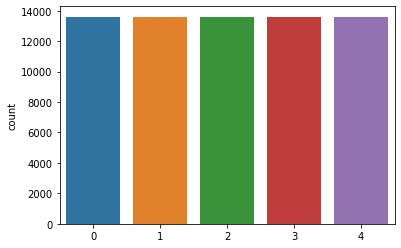

In [4]:
train_files, holdout_files = get_train_holdout_files()